# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Comparison-with-other-transcriptomic-phenotypes" data-toc-modified-id="Comparison-with-other-transcriptomic-phenotypes-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Comparison with other transcriptomic phenotypes</a></div><div class="lev2 toc-item"><a href="#Hypoxia-Response" data-toc-modified-id="Hypoxia-Response-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Hypoxia Response</a></div><div class="lev2 toc-item"><a href="#Dpy-Response" data-toc-modified-id="Dpy-Response-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Dpy Response</a></div><div class="lev2 toc-item"><a href="#The-RAS-pathway" data-toc-modified-id="The-RAS-pathway-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>The RAS pathway</a></div><div class="lev2 toc-item"><a href="#Ras-GF" data-toc-modified-id="Ras-GF-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Ras GF</a></div><div class="lev2 toc-item"><a href="#The-WNT-Pathway" data-toc-modified-id="The-WNT-Pathway-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>The WNT Pathway</a></div>

In this notebook, I will compare the *mdt-12* transcriptomes with the hypoxia, Dpy, Ras and Wnt transcriptional signatures. These signatures in theory ought to serve as powerful predictors of interaction  (for pathways) or as predictors of observable phenotypes (such as Dpy) if they are present in the mutant data. 

In [1]:
import pandas as pd
import numpy as np
import scipy as scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import tissue_enrichment_analysis as tea
import pretty_table as pretty

from scipy import stats

import os
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
q = 0.1
genmap = pd.read_csv('../sleuth/rna_seq_info.txt', sep=' ', comment='#')
tidy  = pd.read_csv('../output/dpy_22_results.csv')
mediator = pd.read_csv('../input/complexes.csv')

In [5]:
tissue = tea.fetch_dictionary('tissue')
phenotype = tea.fetch_dictionary('phenotype')
go = tea.fetch_dictionary('go')
dicts = {'tissue': tissue, 'phenotype': phenotype, 'go': go}

In [20]:
analysis = {}
for phenoclass, group in tidy.groupby('phenotypic class'):
    frames = {}
    for k, d in dicts.items():
        df = tea.enrichment_analysis(group.ens_gene.unique(), d, show=False)
        frames[k] = df
    analysis[phenoclass] = frames

In [25]:
for phenoclass, f in analysis.items():
    for k, d in f.items():
        if d[d['Q value'] < 10**-3][['Tissue', 'Q value']].shape[0]:
            print(phenoclass, k)
            print(d[d['Q value'] < 10**-3][['Tissue', 'Q value']])
            print('----------\n------------')
    print('\n\n')

bx93 associated go
                                          Tissue       Q value
158             immune system process GO:0002376  1.880822e-31
177  glucuronosyltransferase activity GO:0015020  3.695389e-15
165       response to biotic stimulus GO:0009607  3.417327e-13
186             developmental process GO:0032502  3.846234e-07
48                          cytoplasm GO:0005737  5.935778e-06
51                              aging GO:0007568  1.174703e-05
94                      lytic vacuole GO:0000323  2.383556e-04
128            organic acid transport GO:0015849  5.443954e-04
120        membrane-bounded organelle GO:0043227  9.039237e-04
108              extracellular region GO:0005576  9.039237e-04
194                   plasma membrane GO:0005886  9.474101e-04
----------
------------
bx93 associated tissue
                                Tissue       Q value
133             intestine WBbt:0005772  3.273956e-09
30   cephalic sheath cell WBbt:0008406  1.990881e-04
96      epithelial 

# Comparison with other transcriptomic phenotypes

In [3]:
hypoxia = pd.read_csv('../input/hypoxia_response.csv')
dpy = pd.read_csv('../input/dpy_geneset.csv')

In [70]:
# hypergeometric test
def test_classes_hgf(dataset, alpha=10**-6, q=0.1):
    """
    Performs enrichment analysis of each phenotypic class using a provided background dataset.
    
    This function performs a hypergeometric enrichment analysis of each phenotypic class
    compared with a provided background dataset. The results are adjusted for FDR using a 
    conservative Bonferroni correction. 
    
    dataset --- a pandas dataframe. Must contain column `target_id'
    alpha --- statistical significance threshold before Bonferroni
    
    Output:
    None --- prints results to screen
    """
    bonferroni = len(tidy['phenotypic class'].unique())
    space = 20
    print('Only significant values are printed below.')
    pretty.table_print(['Name', 'Found', 'Expected', 'pval'], space=space)
    for name, group in tidy[(tidy.qval < q)].groupby('phenotypic class'):
        found = group[(group.target_id.isin(dataset.target_id))].target_id.unique()
        pval = stats.hypergeom.sf(len(found), len(tidy.target_id.unique()), len(dataset), len(group))
        expected = stats.hypergeom.mean(len(tidy.target_id.unique()), len(dataset), len(group))
        if pval < alpha/bonferroni:
            m = [name, len(found), '{0:.2g}'.format(expected), '{0:.2g}'.format(pval)]
            pretty.table_print(m, space=space)

# spearman
def spearman(dataset, alpha=10**-3, min_frac=0.1, q=0.1):
    """
    Performs Mann Whitney U tests of each genotype using a provided background dataset.
    
    This function performs a Mann Whitney U test on each genotype to compare whether the
    distribution of effects is the same as the provided dataset.
    
    dataset --- a pandas dataframe. Must contain column `target_id'
    alpha --- statistical significance threshold before Bonferroni
    min_frac --- minimum fraction of the dataset that must be found in the test set to
                 test for significance. Defaults to 10%

    Output:
    None --- prints results to screen
    """
    bonferroni = len(tidy.genotype.unique())
    space=25
    print('Only significant results are printed below')
    pretty.table_print(['Name', '% Found', 'Correlation', 'pvalue'], space=space)
    for name, group in tidy[(tidy.qval < q)].groupby('genotype'):
        found = group[(group.target_id.isin(dataset.target_id))]
        if (len(found) < min_frac*len(dataset)) & (len(found) < min_frac*len(group)):
            continue
        spearman = stats.spearmanr(found.b, dataset[dataset.target_id.isin(found.target_id)].b)
        if spearman.pvalue < alpha/bonferroni:
            m = [name, '{0:.2g}%'.format(100*len(found)/len(dataset)), '{0:.2g}'.format(spearman.correlation), '{0:.2g}'.format(spearman.pvalue)]
            pretty.table_print(m, space=space)

def density_color(x, y):
    points = np.vstack([x, y])
    z = scipy.stats.gaussian_kde(points)(points)
    return z

def pretty_plot(x, y, size=5, ax=None, **kwargs):
    if ax is not None:
        ax.scatter(x, y, s=size, **kwargs)
    else:
        fig, ax = plt.subplots()
        ax.scatter(x, y, s=size, **kwargs)
    return ax

def plot_response(dataset, genotype='dpy22-sy622', q=0.1, s0=3, ax=None, **kwargs):
    """Given a dataset, plot the genes that are DE in the specified genotype against the dataset values."""
    label = kwargs.pop('label', True)
    rank = kwargs.pop('rank', None)
    x = tidy[(tidy.target_id.isin(dataset.target_id)) & (tidy.qval < q) & (tidy.genotype == genotype)].copy()
    y = dataset[dataset.target_id.isin(x.target_id)].copy()
    if rank:
        X = x.b.rank()
        Y = y.b.rank()
        color = 'blue'
        size = s0
    else:
        X = x.b
        Y = y.b
        color = density_color(X, Y)
        size = s0/np.sqrt(x.se_b)
    ax = pretty_plot(X, Y, size, ax=ax, c=color, **kwargs)
    if label == True:
        ax.set_xlabel(genotype)
    return ax

## Hypoxia Response

In [51]:
print('test hypoxia dataset for enrichment')
test_classes_hgf(hypoxia)

test hypoxia dataset for enrichment
Only significant values are printed below.
Name                Found               Expected            pval                
bx93 associated     63                  30                  9.9e-09             
sy622 associated    78                  42                  4.4e-08             
sy622 specific      186                 54                  8.8e-55             


In [52]:
print('spearman analysis of hypoxia response')
spearman(hypoxia)

spearman analysis of hypoxia response
Only significant results are printed below
Name                     % Found                  Correlation              pvalue                   


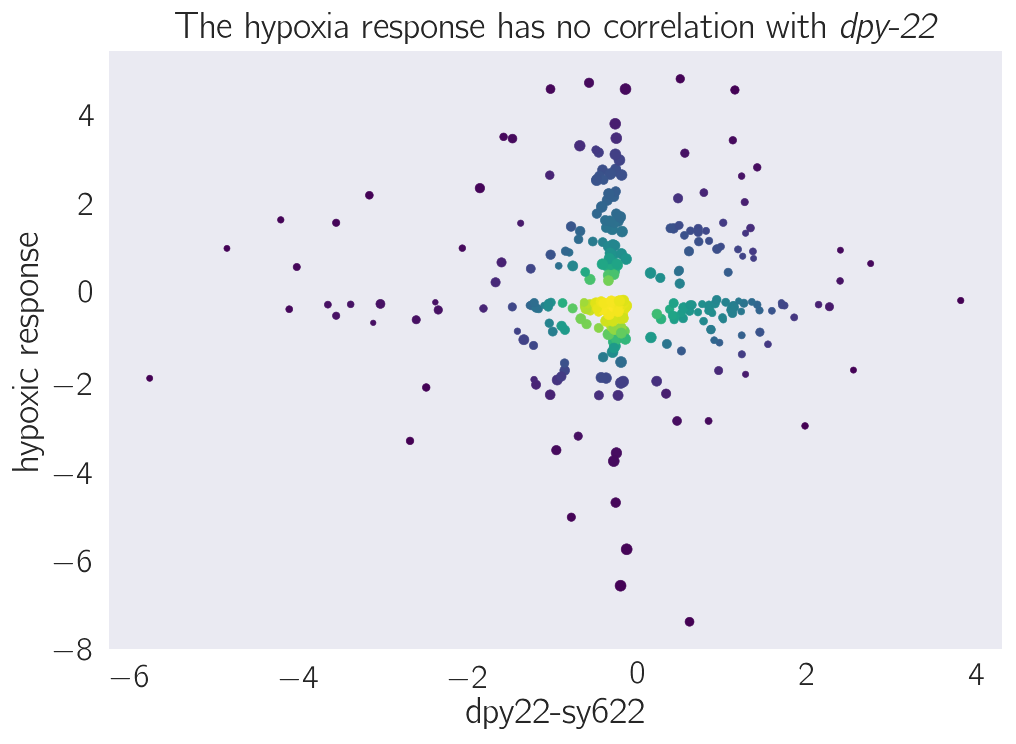

In [53]:
plot_response(hypoxia, cmap='viridis')
plt.ylabel('hypoxic response')
plt.title('The hypoxia response has no correlation with \emph{dpy-22}')

## Dpy Response

In [54]:
print('testing the Dpy dataset')
test_classes_hgf(dpy)

testing the Dpy dataset
Only significant values are printed below.
Name                Found               Expected            pval                
bx93 associated     68                  31                  4.1e-10             
sy622 associated    82                  43                  8.8e-09             
sy622 specific      167                 56                  2.3e-40             


In [55]:
print('spearman analysis of Dpy response')
spearman(dpy)

spearman analysis of Dpy response
Only significant results are printed below
Name                     % Found                  Correlation              pvalue                   
dpy22-sy622              48%                      0.42                     5.7e-15                  


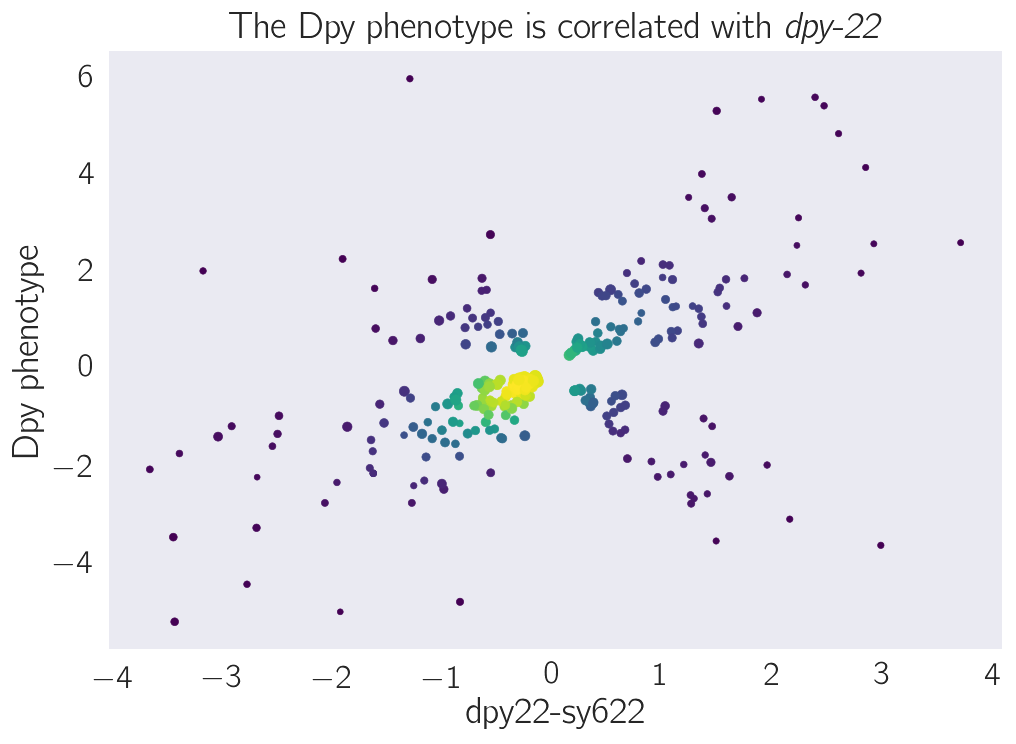

In [56]:
plot_response(dpy, cmap='viridis')
plt.ylabel('Dpy phenotype')
plt.title('The Dpy phenotype is correlated with \emph{dpy-22}')

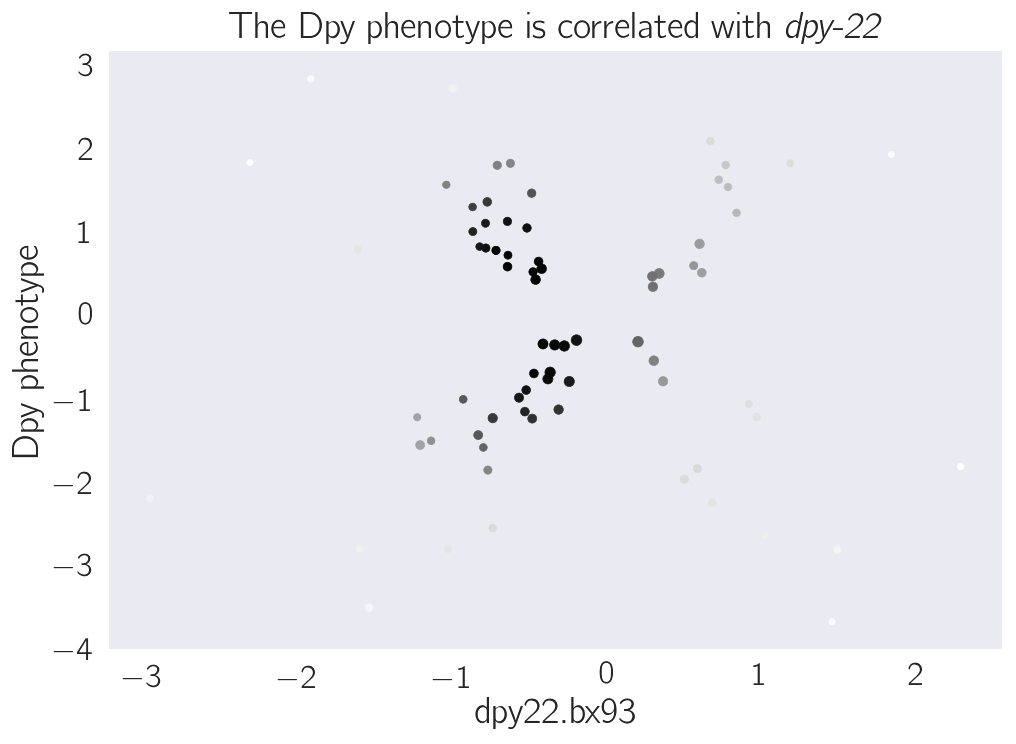

In [57]:
plot_response(dpy, genotype='dpy22.bx93')
plt.ylabel('Dpy phenotype')
plt.title('The Dpy phenotype is correlated with \emph{dpy-22}')

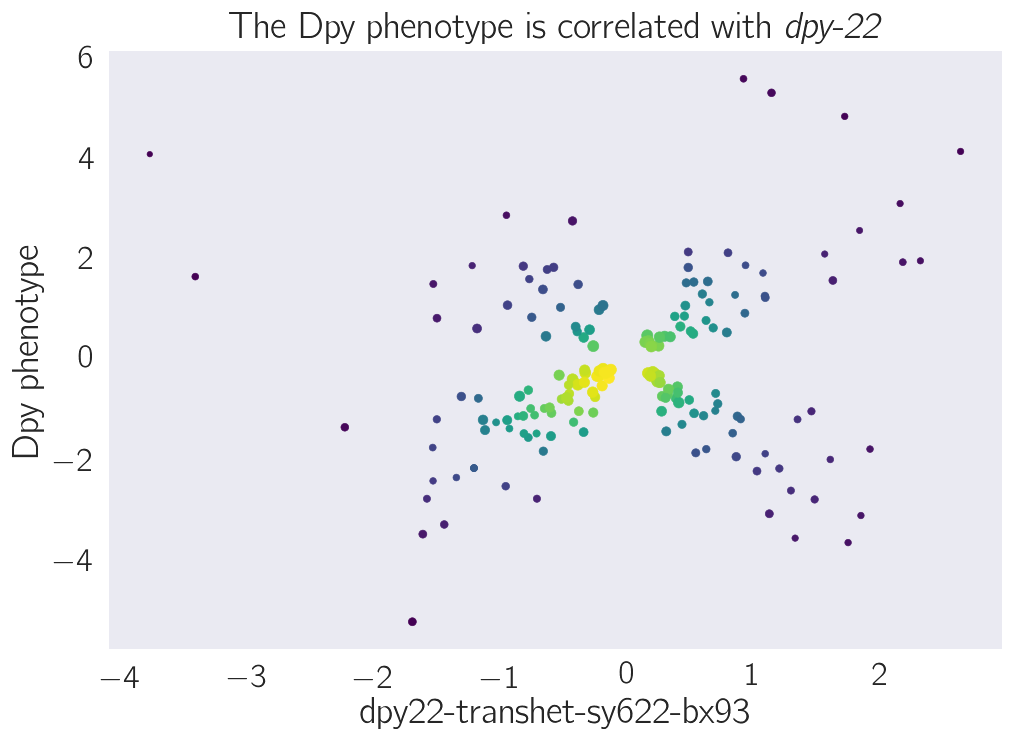

In [58]:
plot_response(dpy, genotype='dpy22-transhet-sy622-bx93', cmap='viridis')
plt.ylabel('Dpy phenotype')
plt.title('The Dpy phenotype is correlated with \emph{dpy-22}')

In [59]:
x = tidy[(tidy.genotype == 'dpy22-sy622') & (tidy.qval < q) & (tidy.target_id.isin(dpy.target_id))].copy()
y = dpy[dpy.target_id.isin(x.target_id)].copy()
y.sort_values('target_id', inplace=True)
x.sort_values('target_id', inplace=True)
y['b_sy622'] = x.b.values

In [60]:
dpy_response = y[y.b*y.b_sy622 > 0]
nondpy_response = y[y.b*y.b_sy622 < 0]
print(len(dpy_response))
print(len(nondpy_response))

233
76


In [61]:
s = stats.spearmanr(dpy_response.sort_values('target_id').b, dpy_response.sort_values('target_id').b_sy622)
s

SpearmanrResult(correlation=0.93823297820869189, pvalue=1.88315112573268e-108)

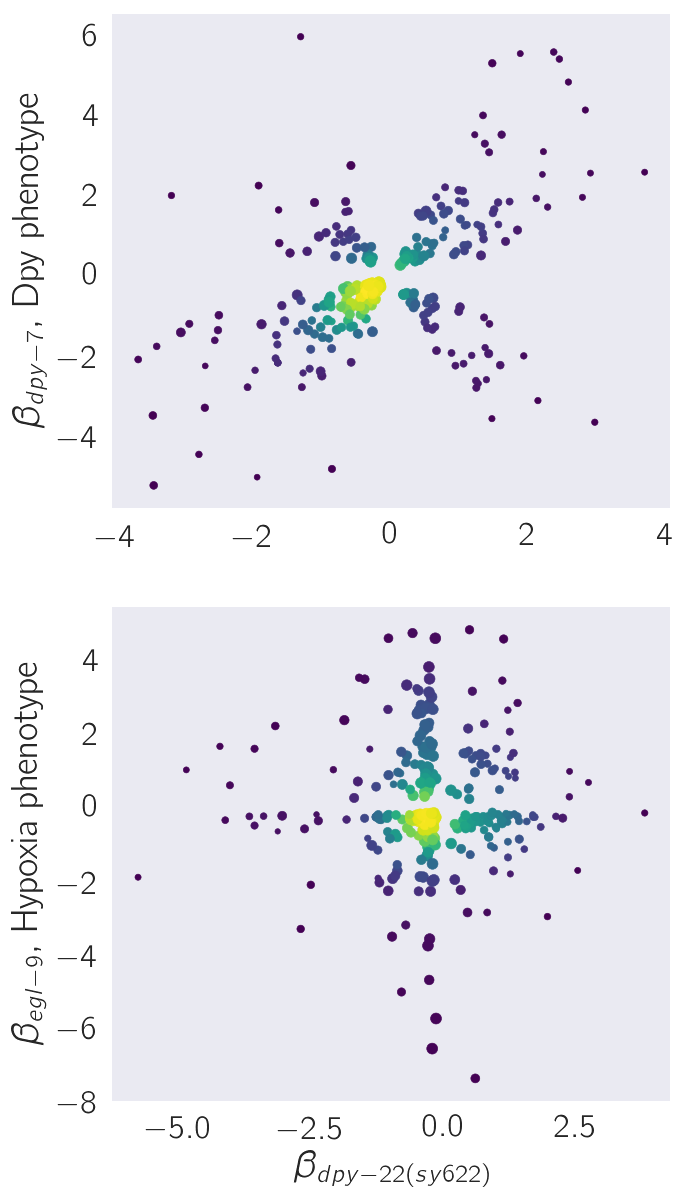

In [62]:
fig, ax = plt.subplots(nrows=2, figsize=(5, 10))

plot_response(dpy, cmap='viridis', ax=ax[0], label=False)
ax[0].set_ylabel(r'$\beta_{dpy-7}$, Dpy phenotype')
# plt.title('The Dpy phenotype is correlated with \emph{dpy-22}')

plot_response(hypoxia, cmap='viridis', ax=ax[1], label=False)
ax[1].set_ylabel(r'$\beta_{egl-9}$, Hypoxia phenotype')
ax[1].set_xlabel(r'$\beta_{dpy-22(sy622)}$')

# for ai in ax:
#     ai.axhline(0, ls='--', lw=1, color='k')
#     ai.axvline(0, ls='--', lw=1, color='k')

plt.savefig('../output/dpy_response.pdf', bbox_inches='tight')

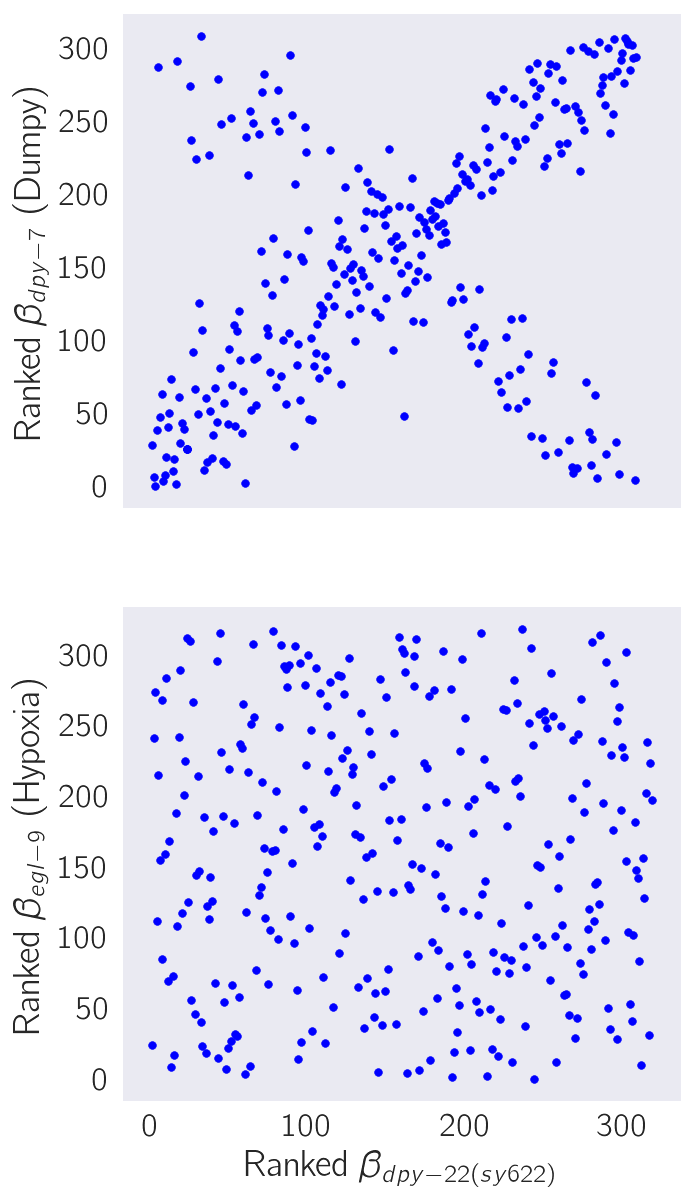

In [71]:
fig, ax = plt.subplots(nrows=2, figsize=(5, 10), sharex=True)

plot_response(dpy, rank=True, cmap='viridis', ax=ax[0], label=False, s0=15)
ax[0].set_ylabel(r'Ranked $\beta_{dpy-7}$ (Dumpy)')
# plt.title('The Dpy phenotype is correlated with \emph{dpy-22}')

plot_response(hypoxia, rank=True, cmap='viridis', ax=ax[1], label=False, s0=15)
ax[1].set_ylabel(r'Ranked $\beta_{egl-9}$ (Hypoxia)')
ax[1].set_xlabel(r'Ranked $\beta_{dpy-22(sy622)}$')


plt.savefig('../output/dpy_response_ranked.pdf', bbox_inches='tight')

## The RAS pathway

In [71]:
ras = pd.read_csv('../input/ras_geneset.csv')

In [72]:
print('test ras dataset for enrichment')
test_classes_hgf(ras)

test ras dataset for enrichment
Only significant values are printed below.
Name                Found               Expected            pval                
bx93 associated     57                  14                  4.3e-21             
sy622 associated    65                  19                  3.2e-19             


In [73]:
print('spearman analysis of Ras response')
spearman(ras)

spearman analysis of Ras response
Only significant results are printed below
Name                     % Found                  Correlation              pvalue                   
dpy22-sy622              58%                      0.59                     5.1e-17                  
dpy22-transhet-sy622-bx9353%                      0.78                     2.6e-32                  
dpy22.bx93               21%                      0.54                     9.5e-06                  


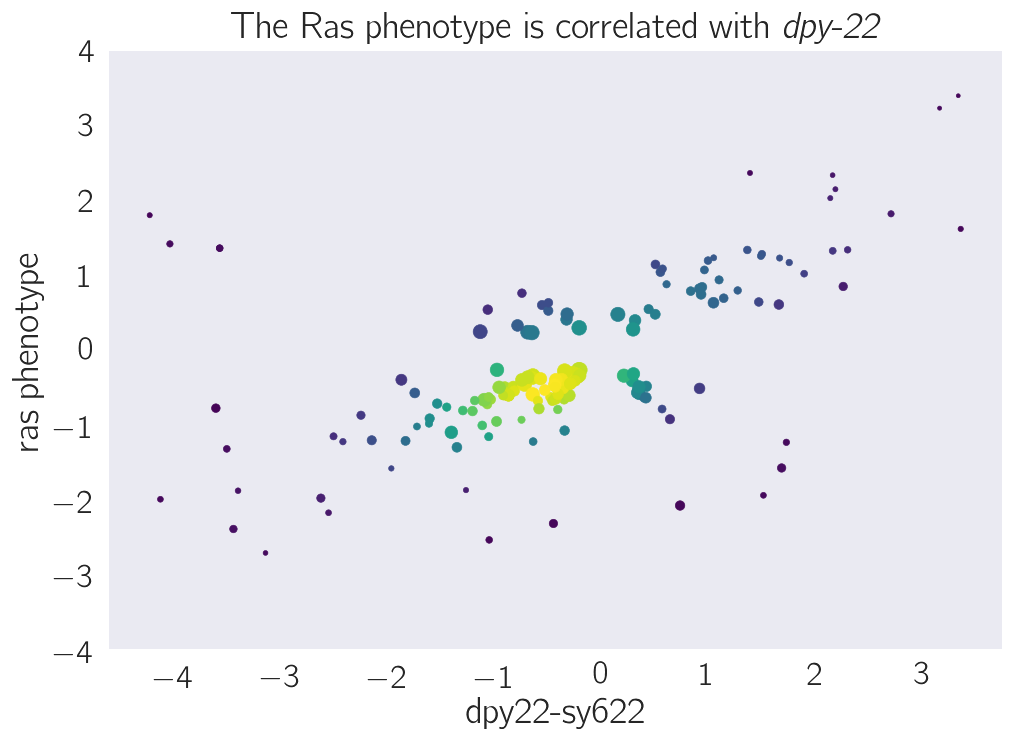

In [74]:
plot_response(ras, cmap='viridis')
plt.ylabel('ras phenotype')
plt.ylim(-4, 4)
plt.title('The Ras phenotype is correlated with \emph{dpy-22}')

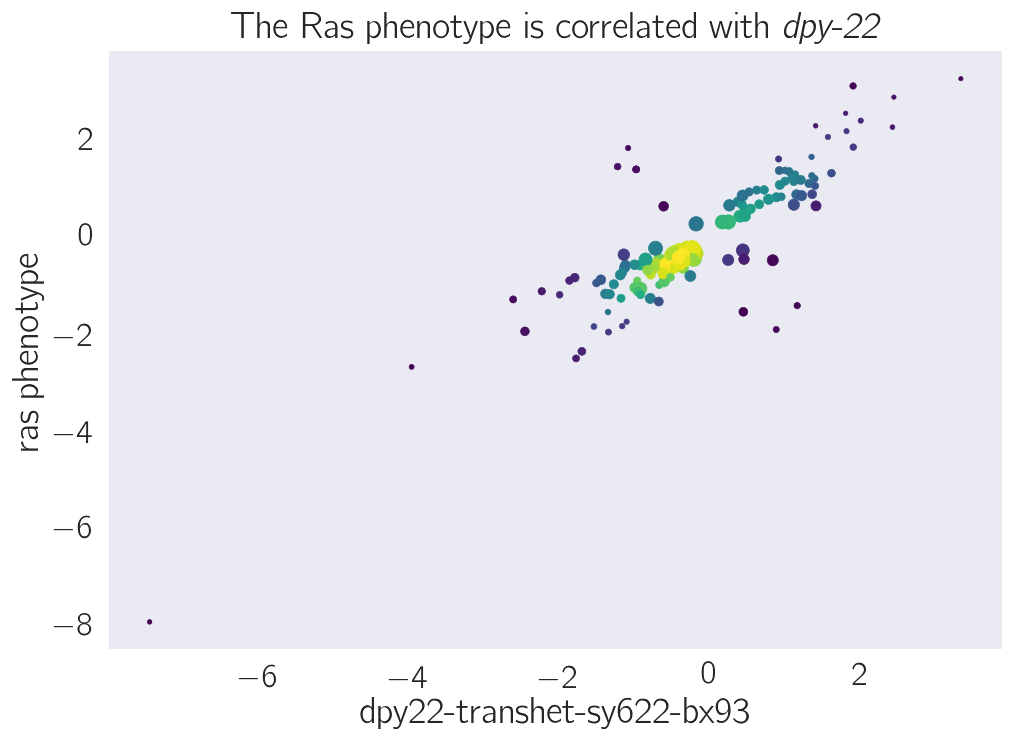

In [87]:
plot_response(ras, genotype='dpy22-transhet-sy622-bx93', cmap='viridis')
plt.ylabel('ras phenotype')
# plt.ylim(-4, 4)
plt.title('The Ras phenotype is correlated with \emph{dpy-22}')

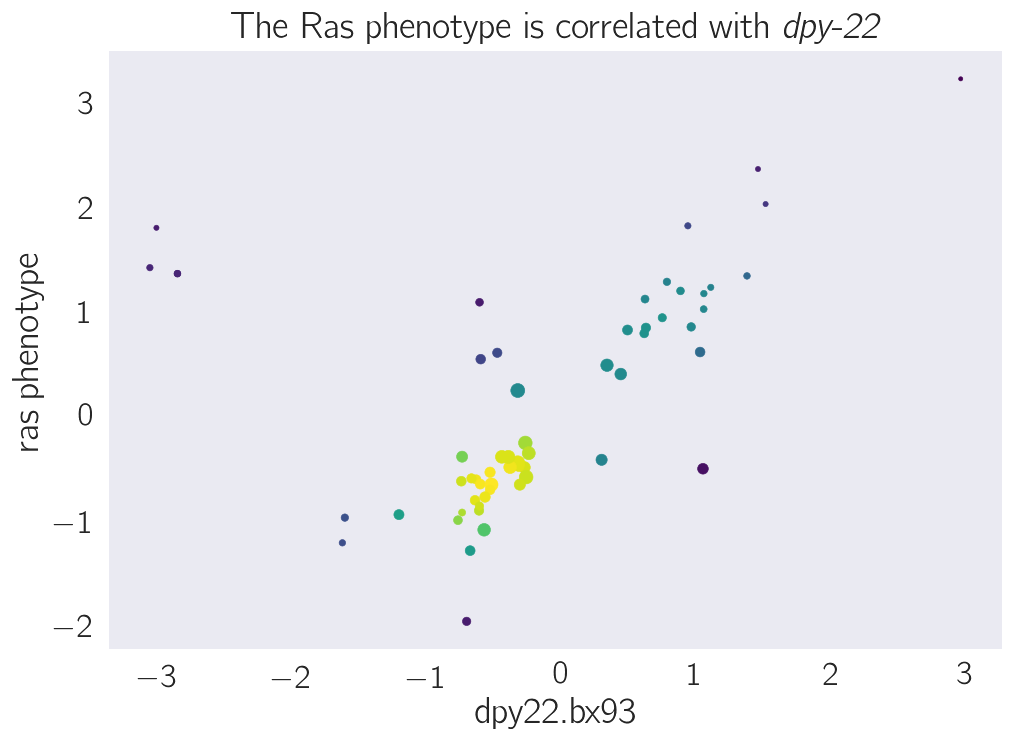

In [88]:
plot_response(ras, genotype='dpy22.bx93', cmap='viridis')
plt.ylabel('ras phenotype')
# plt.ylim(-4, 4)
plt.title('The Ras phenotype is correlated with \emph{dpy-22}')

## Ras GF

In [77]:
rasgf = pd.read_csv('../input/rasgf_geneset.csv')

In [78]:
print('test ras(gf) dataset for enrichment')
test_classes_hgf(rasgf)

print('\n\n----------\n\nspearman analysis of Ras(gf) response')
spearman(rasgf)

test ras(gf) dataset for enrichment
Only significant values are printed below.
Name                Found               Expected            pval                
transhet specific   452                 1.2e+02             2.7e-156            


----------

spearman analysis of Ras(gf) response
Only significant results are printed below
Name                     % Found                  Correlation              pvalue                   
dpy22-sy622              22%                      0.77                     5.3e-90                  
dpy22-transhet-sy622-bx9336%                      0.82                     2.2e-180                 
dpy22.bx93               6.8%                     0.74                     1.8e-26                  


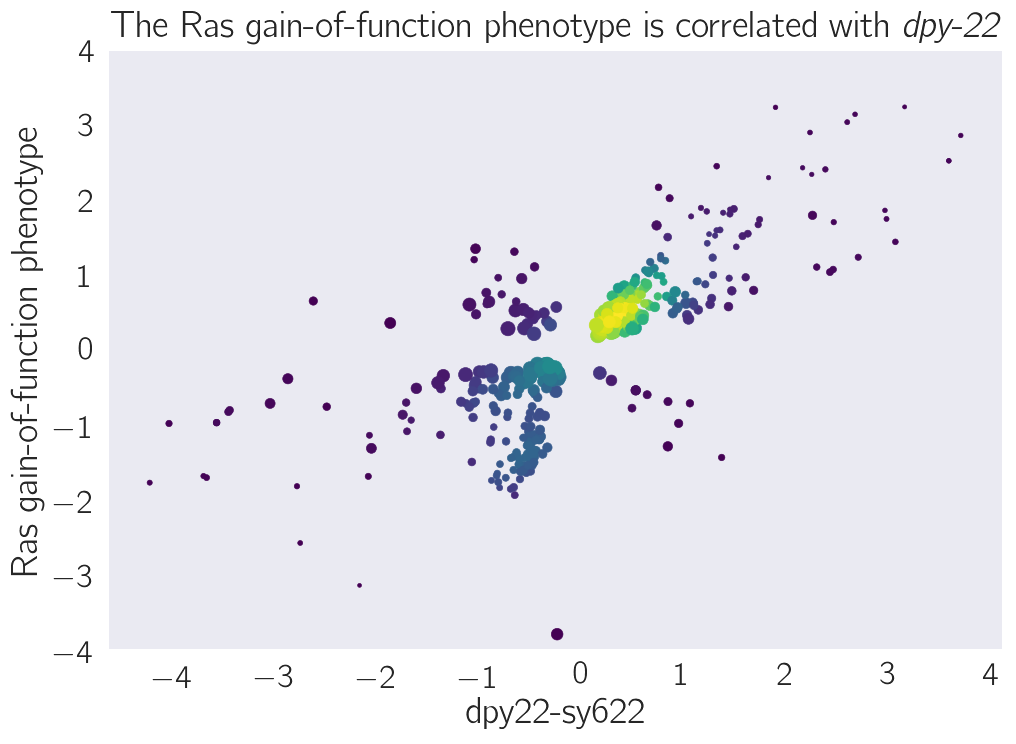

In [89]:
plot_response(rasgf, cmap='viridis')
plt.ylabel('Ras gain-of-function phenotype')
plt.ylim(-4, 4)
plt.title('The Ras gain-of-function phenotype is correlated with \emph{dpy-22}')

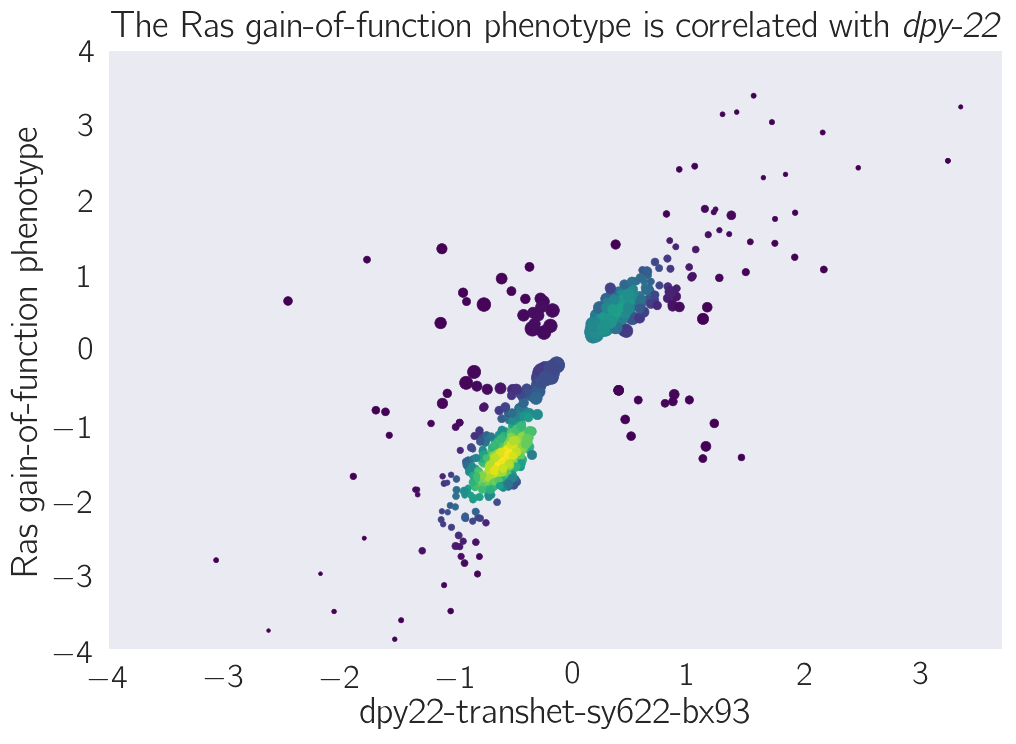

In [90]:
plot_response(rasgf, genotype='dpy22-transhet-sy622-bx93', cmap='viridis')
plt.ylabel('Ras gain-of-function phenotype')
plt.ylim(-4, 4)
plt.title('The Ras gain-of-function phenotype is correlated with \emph{dpy-22}')

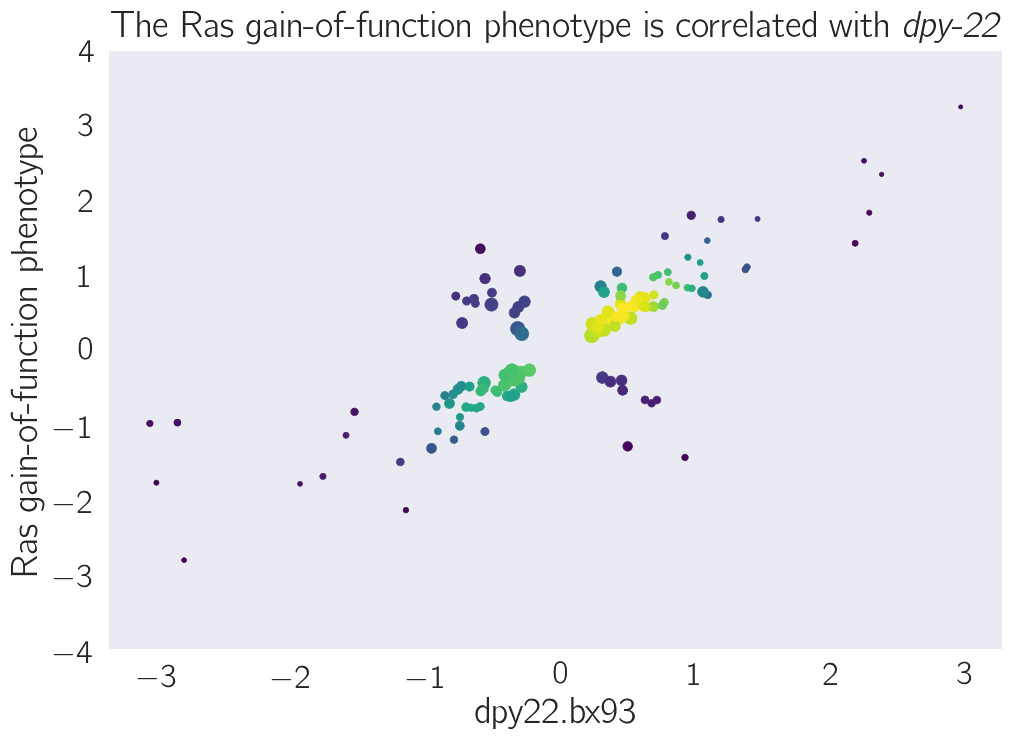

In [91]:
plot_response(rasgf, genotype='dpy22.bx93', cmap='viridis')
plt.ylabel('Ras gain-of-function phenotype')
plt.ylim(-4, 4)
plt.title('The Ras gain-of-function phenotype is correlated with \emph{dpy-22}')

## The WNT Pathway

In [92]:
wnt = pd.read_csv('../input/wnt_geneset.csv')

In [93]:
print('test wnt dataset for enrichment')
test_classes_hgf(wnt)

test wnt dataset for enrichment
Only significant values are printed below.
Name                Found               Expected            pval                
bx93 associated     243                 1.7e+02             7.8e-09             
sy622 associated    396                 2.4e+02             1.1e-25             
sy622 specific      726                 3.1e+02             6.1e-128            
transhet specific   523                 2.1e+02             4.7e-106            


In [84]:
print('spearman analysis of Wnt response')
spearman(wnt)

spearman analysis of Wnt response
Only significant results are printed below
Name                     % Found                  Correlation              pvalue                   
dpy22-sy622              37%                      0.81                     4.7e-315                 
dpy22-transhet-sy622-bx9330%                      0.78                     5.5e-227                 
dpy22.bx93               7.3%                     0.73                     8.2e-45                  


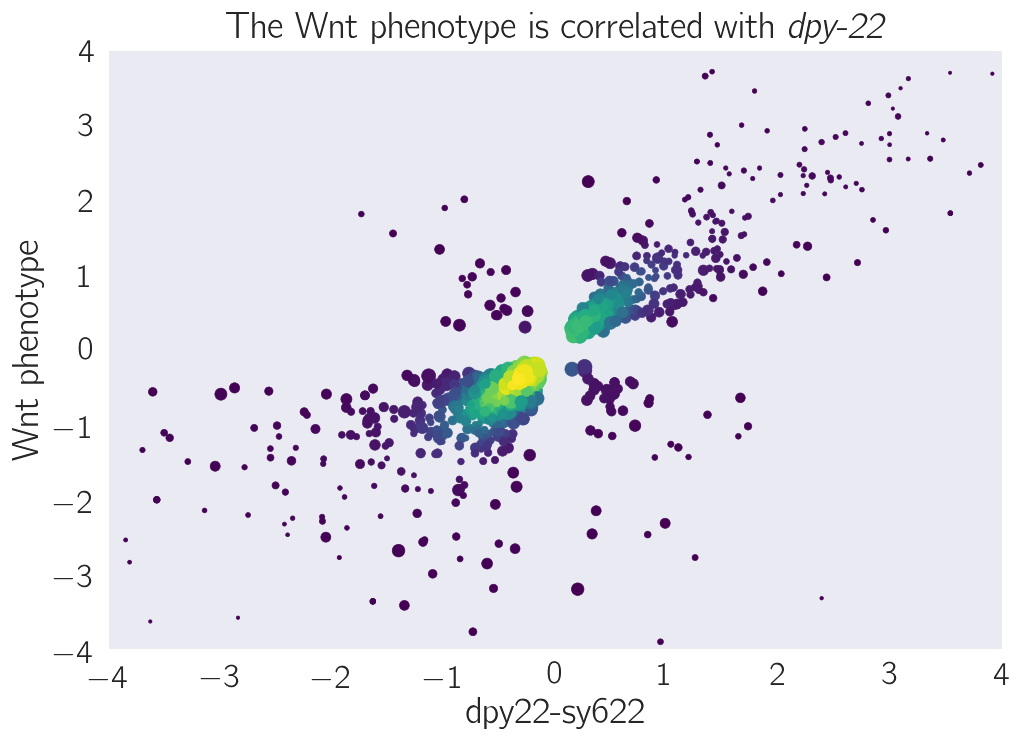

In [85]:
plot_response(wnt, genotype='dpy22-sy622', cmap='viridis')

plt.xlim(-4, 4)
plt.ylim(-4, 4)

plt.ylabel('Wnt phenotype')
plt.title('The Wnt phenotype is correlated with \emph{dpy-22}')

plt.savefig('../output/wnt_interaction.pdf', bbox_inches='tight')